<a href="https://colab.research.google.com/github/Arus3107/Machine-learning-for-NLP-1/blob/main/TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Nicolas Angleraud, M1 LI



# Sentiment Analysis with sklearn

## 1. Data preparation

In [253]:
!pip install sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [254]:
from sacremoses import MosesTokenizer
import json
corpus = json.load(open("tweet_airlines.json", "r"))

In [255]:
print("number of tweets:", len(corpus))

neutral = 0
positive = 0
negative = 0
for dico in corpus:
  label = dico["label"]
  if label == "positive":
    positive += 1
  elif label == "negative":
    negative += 1
  else:
    neutral += 1

print("positive proportion:", positive/len(corpus))
print("negative proportion:", negative/len(corpus))
print("neutral proportion:", neutral/len(corpus))

number of tweets: 14640
positive proportion: 0.16140710382513662
negative proportion: 0.6269125683060109
neutral proportion: 0.21168032786885246


### Interprétation de la distribution des données
Les données ont une distribution déséquilibrée donc il faut faire attention à la métrique utilisée pour interpréter les résultats que l'on obtiendra. On sait par exemple que la macro accuracy sera plus pertinente que la micro accuracy car elle traite toutes les classes de manière équitable contrairement à la micro accuracy qui est très sensible à la distribution des données.

In [297]:
from sacremoses import MosesTokenizer

mt = MosesTokenizer(lang='en')
mt.tokenize("@SouthwestAir don't you think a 4hr wait time", 
            return_str=True, 
            escape=False,
            protected_patterns=mt.WEB_PROTECTED_PATTERNS)


"@SouthwestAir don 't you think a 4hr wait time"

### Explication moses et fonction tokenize
Moses est un outil de tokenization qui gère plusieurs langues différentes.
La fonction tokenize prend une chaine de caractères et la même chaine avec tous les éléments unitaires séparés par un espace. Cela permet de manipuler les mots et expressions contenus dans chaque tweet du corpus plus facilement ensuite. Le paramètre return_str est fixé à True afin de ne pas renvoyer une liste de mots mais bien une phrase avec chaque mot/expression séparé par un espace. Le paramètre escape est fixé à False pour conserver l'affichage des caratères spéciaux et ne pas les transcrires dans leur expression spéciale. Le WEB_PROTECTED_PATTERNS permet de conserver certains patterns de caractères et de ne pas les séparer par un espace lors de la tokenization, comme le '@' par exemple que l'on souhaite laisser attacher au mot qui suit.

In [257]:
def tokenize_sentences(list_of_sentences):
  return [mt.tokenize(tweet, return_str=True, escape=False, protected_patterns=mt.WEB_PROTECTED_PATTERNS) for tweet in list_of_sentences]

In [258]:
def extract_sentences(corpus):
  sentences = []
  for tweet in corpus:
    sentences.append(tweet["tweet"])
  return sentences

In [259]:
def extract_labels(corpus):
  labels = []
  for label in corpus:
    labels.append(label["label"])
  return labels

In [299]:
tweets = extract_sentences(corpus)
#print(tokenize_sentences(tweets))

In [261]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#vectorizer = TfidfVectorizer(max_features=2_500,
#                             min_df=7,
#                             max_df=0.8)
#X = vectorizer.fit_transform(tokenize_sentences(corpus))
#y = extract_labels(corpus)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


### Explication erreur
Si on vectorise les données avant de les séparer en deux sets test et train différents et indépendants alors les données des deux sets seront liées et cela va fausser les résultats du code utilisé pour entrainer le classifier et le tester sur des données. En effet, en faisant ainsi la fonction d'évaluation va plus facilement évaluer correctement les données du set test car il aura joué dans l'entrainement du classifier d'une certaine manière à cause de la non indépendance de test et train. 

In [262]:
vectorizer = TfidfVectorizer(max_features=2_500,
                             min_df=7,
                             max_df=0.8)
X = tokenize_sentences(extract_sentences(corpus))
y = extract_labels(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

### Explication paramètres vectorizer
max_features donne le nombre maximal de features que l'on va extraire avec la fonction. min_df indique que les features qui apparaissent dans moins de 7 phrases ne seront pas conservés. max_df indique que les features qui apparaissent dans plus de 80% des phrases ne seront pas conservés. L'objectif est d'optimiser l'extraction de features afin de ne pas s'encombrer d'éléments qui apparaissent trop peu ou trop souvent. Dans le premier cas, ces éléments ne sont pas pertinents pour l'évaluation car ils ne semblent pas déterminants dans la plupart des données, dans le second cas, il s'agit d'éléments triviaux qui sont présents dans la plupart des phrases et qui ne portent pas en eux une indication sur le fait de dire qu'un tweet est positif, neutre ou négatif.

In [263]:
#print(X.shape[1])
print(X_train_vectorized.shape[1])
print(X_test_vectorized.shape[1])

#print(X.shape[0])
print(X_train_vectorized.shape[0])
print(X_test_vectorized.shape[0])

2103
2103
11712
2928


### Nombre de features extraits
Lorsque X est vectorisé, il comporte deux dimensions: les features extraits et les phrases du corpus. X_train possède 80% des phrases du corpus et X_test 20%. La dimension qu'ils ont en commun est le nombre de features. On peut donc en conclure que le nombre de features extraits est 2103.

In [264]:
print(type(X_train_vectorized))
print(X_train_vectorized.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(11712, 2103)


### Type et Size de X_train
X_train est un objet de type sparse matrix. Il s'agit d'une matrice qui contient principalement des 0. Pour certaines structures de données il s'agit d'un objet qui optimise la programmation car elle permet de stocker plus efficacement et d'améliorer la vitesse d'exécution. Il s'agit ici d'une matrice qui stocke les phrases du set et les features associés à chaque phrase.


In [283]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=200)
clf.fit(X_train_vectorized, y_train)

RandomForestClassifier(n_estimators=200)

In [298]:
from sklearn.metrics import accuracy_score
y_train_predicted = clf.predict(X_train_vectorized)
y_test_predicted = clf.predict(X_test_vectorized)


print("accuracy score for test set :",accuracy_score(y_test, y_test_predicted))
print("accuracy score for train set :",accuracy_score(y_train, y_train_predicted))

accuracy score for test set : 0.7496584699453552
accuracy score for train set : 0.9963285519125683


### Accuracy score avec le classifier
L'accuracy score est très élevé sur le train set puisqu'il s'agit des données qui ont servit à construire le classifier et ont un impact déterminant sur la fonction d'évaluation.
L'accuracy score d'un classifier qui retourne toujours la classe majoritaire serait de 0.6 puisque dans 60% des cas le label est 'négatif'.
L'accuracy score d'un classifier qui prendrait des décisions aléatoires serait 1/3 puisqu'il y a trois labels différents.
Ces classifiers ne seraient pas pertinents puisqu'ils seraient peu précis et parce qu'ils ne prennent pas en compte la complexité du problème d'évaluation.

In [267]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_train, y_train_predicted, labels = ["positive","neutral","negative"]))

[[1914    7    2]
 [  20 2464    4]
 [   1    9 7291]]


In [268]:
conf_matrix_test = confusion_matrix(y_test, y_test_predicted, labels = ["positive","neutral","negative"])
print(conf_matrix_test)

[[ 203   51  186]
 [  38  212  361]
 [  24   73 1780]]


### Confusion matrix
Une matrice de confusion est une matrice qui indique sur la diagonale le nombre d'objets bien évalués par la fonction du classifier et les autres valeurs correspondent aux erreurs de prédiction dans tous les cas de figure possible. Les lignes correspondent aux labels gold et les colonnes aux lablels prédits. Par exemple la première ligne correspond aux labels 'positive' bien trouvés, puis aux labels 'neutral' prédits à la place de 'positive' et enfin les labels 'negative' là il s'agit en réalité de 'positive'.

In [269]:
print("micro_accuracy(test_set) = ", (conf_matrix_test[0][0]+conf_matrix_test[1][1]+conf_matrix_test[2][2])/len(X_test))
pred_positive = conf_matrix_test[0][0] + conf_matrix_test[0][1] + conf_matrix_test[0][2]
pred_neutral = conf_matrix_test[1][0] + conf_matrix_test[1][1] + conf_matrix_test[1][2]
pred_negative = conf_matrix_test[2][0] + conf_matrix_test[2][1] + conf_matrix_test[2][2]
print("macro_accuracy(test_set) = ", ((conf_matrix_test[0][0])/pred_positive + (conf_matrix_test[1][1])/pred_neutral + (conf_matrix_test[2][2])/pred_negative) / 3)

micro_accuracy(test_set) =  0.7496584699453552
macro_accuracy(test_set) =  0.585552534404539


In [270]:
from sklearn.metrics import f1_score

def micro_accuracy(gold, pred):
  return accuracy_score(gold, pred)

def macro_accuracy(gold, pred):
  return sum(f1_score(gold, pred, average=None))/3

In [271]:
print("micro_accuracy(test_set) = ", micro_accuracy(y_test, y_test_predicted))
print("macro_accuracy(test_set) = ", macro_accuracy(y_test, y_test_predicted))

micro_accuracy(test_set) =  0.7496584699453552
macro_accuracy(test_set) =  0.623476252313448


### Interprétation accuracy/confusion matrix
La micro_accuracy est égale à l'accuracy_score de sklearn. La macro_accuracy correspond à la moyenne pour tous les labels de chaque f1-score qui prend en compte les métriques de precision et recall de chaque label. La macro_accuracy est assez faible donc le classifier utilisé de RandomForest à 200 arbres n'est pas très efficace pour nos données du problème.

In [272]:
import numpy as np
import time

start_time = time.time()
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.065 seconds


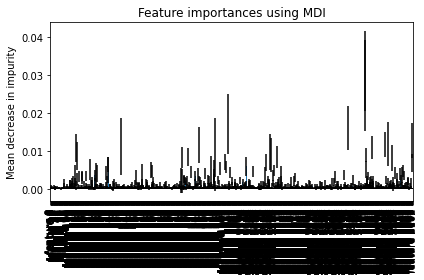

In [273]:
import pandas as pd
import matplotlib.pyplot as plt

feature_names = [f"feature {i}" for i in range(X_test_vectorized.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

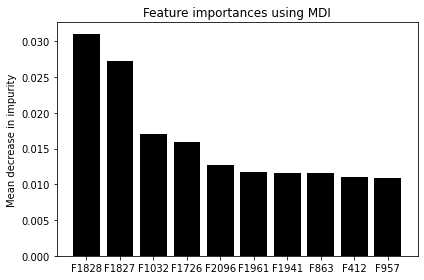

In [293]:
import pandas as pd
import matplotlib.pyplot as plt

feature_names = [f"F{i}" for i in range(X_test_vectorized.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)

forest_importances_ten = forest_importances.sort_values(ascending = False)[0:10]
feature_names = forest_importances_ten.index

fig, ax = plt.subplots()
for feature, feature_name in zip(forest_importances_ten, feature_names):
  plt.bar(feature_name, feature, color='black')
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

In [275]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state = 0, max_iter = 1000)
clf.fit(X_train_vectorized, y_train)
y_test_predicted_lr = clf.predict(X_test_vectorized)
print("micro_accuracy(test_set) = ",micro_accuracy(y_test, y_test_predicted_lr))
print("macro_accuracy(test_set) = ",macro_accuracy(y_test, y_test_predicted_lr))

micro_accuracy(test_set) =  0.7988387978142076
macro_accuracy(test_set) =  0.7183711935937529


In [276]:
from sklearn.linear_model import Perceptron

clf = Perceptron(random_state = 0)
clf.fit(X_train_vectorized, y_train)
y_test_predicted = clf.predict(X_test_vectorized)
print("micro_accuracy(test_set) = ",micro_accuracy(y_test, y_test_predicted))
print("macro_accuracy(test_set) = ",macro_accuracy(y_test, y_test_predicted))

micro_accuracy(test_set) =  0.7609289617486339
macro_accuracy(test_set) =  0.676740758493047


In [277]:
clf = RandomForestClassifier(n_estimators=20)
clf.fit(X_train_vectorized, y_train)
y_test_predicted = clf.predict(X_test_vectorized)
print("micro_accuracy(test_set) = ",micro_accuracy(y_test, y_test_predicted))
print("macro_accuracy(test_set) = ",macro_accuracy(y_test, y_test_predicted))

micro_accuracy(test_set) =  0.7411202185792349
macro_accuracy(test_set) =  0.6126149739009693


In [278]:
clf = RandomForestClassifier(n_estimators=2000)
clf.fit(X_train_vectorized, y_train)
y_test_predicted = clf.predict(X_test_vectorized)
print("micro_accuracy(test_set) = ",micro_accuracy(y_test, y_test_predicted))
print("macro_accuracy(test_set) = ",macro_accuracy(y_test, y_test_predicted))

micro_accuracy(test_set) =  0.7486338797814208
macro_accuracy(test_set) =  0.6224466384679345


In [279]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train_vectorized, y_train)
y_test_predicted = clf.predict(X_test_vectorized)
print("micro_accuracy(test_set) = ",micro_accuracy(y_test, y_test_predicted))
print("macro_accuracy(test_set) = ",macro_accuracy(y_test, y_test_predicted))

micro_accuracy(test_set) =  0.6277322404371585
macro_accuracy(test_set) =  0.5674080684030002


In [280]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train_vectorized, y_train)
y_test_predicted = clf.predict(X_test_vectorized)
print("micro_accuracy(test_set) = ",micro_accuracy(y_test, y_test_predicted))
print("macro_accuracy(test_set) = ",macro_accuracy(y_test, y_test_predicted))

micro_accuracy(test_set) =  0.7155054644808743
macro_accuracy(test_set) =  0.6317957069386849


In [281]:
clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(X_train_vectorized, y_train)
y_test_predicted = clf.predict(X_test_vectorized)
print("micro_accuracy(test_set) = ",micro_accuracy(y_test, y_test_predicted))
print("macro_accuracy(test_set) = ",macro_accuracy(y_test, y_test_predicted))

micro_accuracy(test_set) =  0.7404371584699454
macro_accuracy(test_set) =  0.6464166207659789


### Conclusion
Le classifier qui a la meilleure macro_accuracy pour notre test_set est le classifier LogisticRegression donc on peut en déduire qu'il s'agit du meilleure classifier parmi ceux entrainés pour notre problème. Le classifier Perceptron est assez proche derrière. Cependant la macro accuracy de ces deux classifier reste assez faible (en dessous de 0.75) et peu satisfaisante pour l'évaluation de nouvelles données, notre fonction d'évaluation se trompe plus d'une fois sur quatre en moyenne.

### Performance on unseen data
Les résultats déterminés ne suiffisent pas vraiment à connaitre les performances du classifier sur les données non-vues. Ils permettent d'avoir des informations sur l'erreur empirique qui peut servir à apporcher l'erreur générale. Cependant il serait préférable d'utiliser un troisième set de données (train, validation et test) afin de mieux ajuster le classfier pour traiter les données d'un problèmes.